In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.quantization
import time
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.models.resnet import ResNet, BasicBlock
from torch.nn.quantized import FloatFunctional
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [9]:
torch.manual_seed(1910)
NUM_EPOCHS = 5
# NEW: Your local machine might not have a GPU, this will correctly fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Dataset used: CIFAR-10") # NEW: Stating the dataset upfront


Using device: cuda
Dataset used: CIFAR-10


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
print("CIFAR-10 dataset loaded.")


Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset loaded.


In [11]:
class QuantizableBasicBlock(BasicBlock):
    def __init__(self, *args, **kwargs):
        super(QuantizableBasicBlock, self).__init__(*args, **kwargs)
        self.add_relu = FloatFunctional()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.add_relu.add_relu(out, identity)
        return out

class QuantizableResNet(ResNet):
    def __init__(self, *args, **kwargs):
        super(QuantizableResNet, self).__init__(*args, **kwargs)
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self._forward_impl(x)
        x = self.dequant(x)
        return x
        
    def fuse_model(self):
        torch.quantization.fuse_modules(self, ['conv1', 'bn1', 'relu'], inplace=True)
        for module_name, module in self.named_children():
            if "layer" in module_name:
                for basic_block_name, basic_block in module.named_children():
                    torch.quantization.fuse_modules(
                        basic_block, [['conv1', 'bn1', 'relu'], ['conv2', 'bn2']], inplace=True
                    )


In [12]:
def train_model(model, trainloader, criterion, optimizer, num_epochs=5):
    print(f"\nStarting fine-tuning for {num_epochs} epochs on {device}...")
    start_time = time.time() # NEW: Start timer
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(trainloader):.3f}")
    
    end_time = time.time() # NEW: End timer
    training_time = end_time - start_time
    print(f"Fine-tuning complete in {training_time:.2f} seconds.")
    return model, training_time

float_model = QuantizableResNet(block=QuantizableBasicBlock, layers=[2, 2, 2, 2])
float_model.load_state_dict(torchvision.models.resnet18(weights='IMAGENET1K_V1').state_dict())
num_ftrs = float_model.fc.in_features
float_model.fc = nn.Linear(num_ftrs, 10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(float_model.parameters(), lr=0.001, momentum=0.9)
trained_float_model, training_time = train_model(float_model, trainloader, criterion, optimizer, num_epochs=NUM_EPOCHS)



Starting fine-tuning for 5 epochs on cuda...
Epoch [1/5] Loss: 0.401
Epoch [2/5] Loss: 0.150
Epoch [3/5] Loss: 0.084
Epoch [4/5] Loss: 0.045
Epoch [5/5] Loss: 0.028
Fine-tuning complete in 1271.18 seconds.


In [13]:
ptq_model = copy.deepcopy(trained_float_model)
ptq_model.to('cpu')
ptq_model.eval()
ptq_model.fuse_model()
print("\nModel modules fused.")

# NEW: Use 'fbgemm' for your local x86 machine for best performance
torch.backends.quantized.engine = 'fbgemm'
ptq_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(ptq_model, inplace=True)
print("Model prepared for calibration.")

print("Running calibration...")
with torch.no_grad():
    for i, (images, _) in enumerate(testloader):
        ptq_model(images)
        if i >= 100:
            break
print("Calibration complete.")
quantized_integer_model = torch.quantization.convert(ptq_model)
print("Model successfully converted to a final integer model.")



Model modules fused.
Model prepared for calibration.
Running calibration...


c:\Users\VICTUS\anaconda3\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Calibration complete.
Model successfully converted to a final integer model.


In [14]:
def get_model_size_mb(model):
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p") / 1e6
    os.remove("temp.p")
    return size_mb

# MODIFIED: Now returns all metrics including lists for confusion matrix
def evaluate_model(model, data_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    
    all_labels = []       # NEW
    all_predictions = []  # NEW
    
    start_time = time.time()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())             # NEW
            all_predictions.extend(predicted.cpu().numpy())     # NEW
            
    end_time = time.time()
    total_inference_time = end_time - start_time
    avg_latency_ms = (total_inference_time / len(data_loader.dataset)) * 1000
    accuracy = 100 * correct / total
    
    return accuracy, avg_latency_ms, total_inference_time, all_labels, all_predictions

# --- Run Evaluations ---
print("\n--- Evaluating Performance ---")
float_accuracy, float_latency, float_inference_time, float_labels, float_preds = evaluate_model(trained_float_model, testloader, device='cpu')
float_size = get_model_size_mb(trained_float_model)

quant_accuracy, quant_latency, quant_inference_time, quant_labels, quant_preds = evaluate_model(quantized_integer_model, testloader, device='cpu')
quant_size = get_model_size_mb(quantized_integer_model)

# --- Print Detailed Stats ---
print("\n--- DETAILED METRICS ---")
print("\n--- Fine-Tuned Float Model ---")
print(f"Dataset: CIFAR-10")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Accuracy: {float_accuracy:.2f}%")
print(f"Total Inference Time (on test set): {float_inference_time:.2f} seconds")
print(f"Average Latency per Image: {float_latency:.4f} ms")
print(f"Model Size: {float_size:.2f} MB")

print("\n--- PTQ Integer Model ---")
print(f"Dataset: CIFAR-10")
print(f"Accuracy: {quant_accuracy:.2f}%")
print(f"Total Inference Time (on test set): {quant_inference_time:.2f} seconds")
print(f"Average Latency per Image: {quant_latency:.4f} ms")
print(f"Model Size: {quant_size:.2f} MB")



--- Evaluating Performance ---

--- DETAILED METRICS ---

--- Fine-Tuned Float Model ---
Dataset: CIFAR-10
Training Time: 1271.18 seconds
Accuracy: 95.26%
Total Inference Time (on test set): 245.74 seconds
Average Latency per Image: 24.5742 ms
Model Size: 44.80 MB

--- PTQ Integer Model ---
Dataset: CIFAR-10
Accuracy: 94.97%
Total Inference Time (on test set): 194.59 seconds
Average Latency per Image: 19.4585 ms
Model Size: 11.32 MB


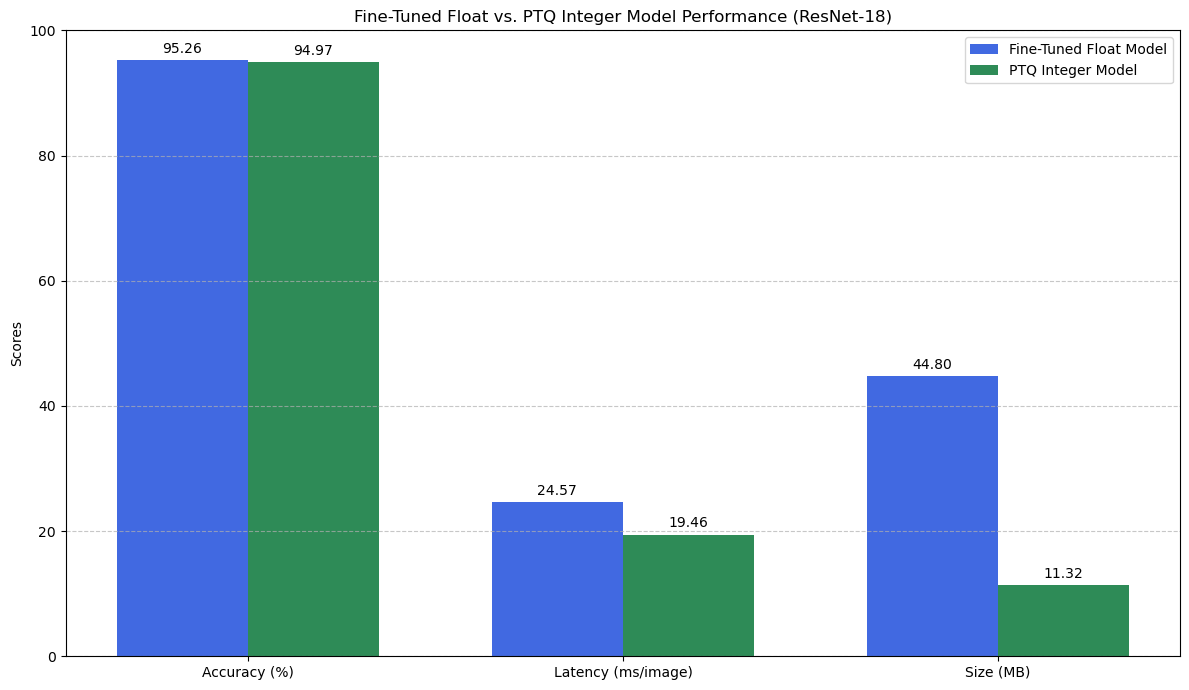

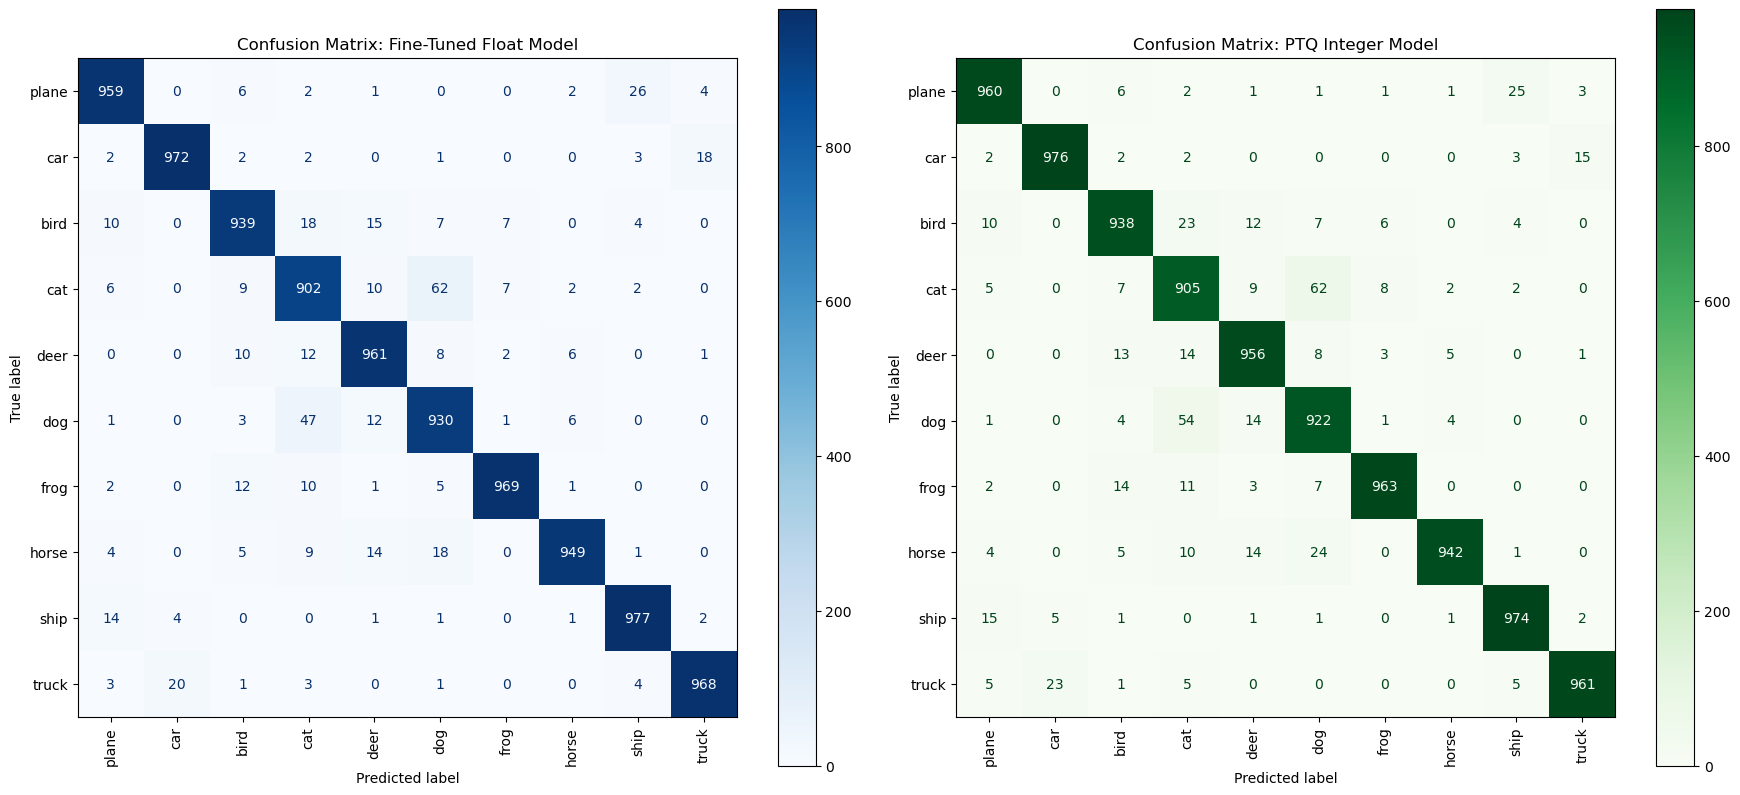

In [15]:
labels = ['Accuracy (%)', 'Latency (ms/image)', 'Size (MB)']
quant_metrics = [quant_accuracy, quant_latency, quant_size]
float_metrics = [float_accuracy, float_latency, float_size]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width / 2, float_metrics, width, label='Fine-Tuned Float Model', color='royalblue')
rects2 = ax.bar(x + width / 2, quant_metrics, width, label='PTQ Integer Model', color='seagreen')
ax.set_ylabel('Scores')
ax.set_title('Fine-Tuned Float vs. PTQ Integer Model Performance (ResNet-18)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
fig.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Confusion Matrix ---
cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Float Model Confusion Matrix
cm_float = confusion_matrix(float_labels, float_preds)
disp_float = ConfusionMatrixDisplay(confusion_matrix=cm_float, display_labels=cifar_classes)
disp_float.plot(ax=ax[0], xticks_rotation='vertical', cmap='Blues')
ax[0].set_title('Confusion Matrix: Fine-Tuned Float Model')

# Quantized Model Confusion Matrix
cm_quant = confusion_matrix(quant_labels, quant_preds)
disp_quant = ConfusionMatrixDisplay(confusion_matrix=cm_quant, display_labels=cifar_classes)
disp_quant.plot(ax=ax[1], xticks_rotation='vertical', cmap='Greens')
ax[1].set_title('Confusion Matrix: PTQ Integer Model')

plt.tight_layout()
plt.show()